### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from models.pinn import SOSIFixed, SOSIRandom, MOMIFixed
import keras_core as keras
import numpy as np
from models.analytical import SingleOccupationSingleIsotope, MultiOccupationMultiIsotope
from training.utils import SearchModelGenerator, random_search, ParameterRange, SearchModel
import matplotlib.pyplot as plt

Using PyTorch backend.


# Single-Occupation, Single Isotope, fixed matrix model

## Random Search

In [9]:
def reject(search_model: SearchModel):
    return search_model.cpu_inference > 15e-6 # 15 microseconds
sosi_fixed_generator = SearchModelGenerator(
    SOSIFixed(),
    layer_count=ParameterRange([1, 5]),
    layer_sizes=ParameterRange([16, 32, 64, 128, 256, 512, 1024]),
    activations=ParameterRange(["relu", "tanh", "leaky_relu", "sigmoid"]),
    output_activation=ParameterRange(["relu", "leaky_relu", "linear"]),
    physics_weight=ParameterRange([0, 0.1]),
    reject=reject,
)
models = random_search(sosi_fixed_generator, 100, "random_search/15µs_leaky_relu")

  0%|          | 0/100 [00:00<?, ?it/s]

Training {'dataset_name': 'Single-Occupation, Single Isotope, fixed matrix', 'dataset_dir': 'datasets', 'epochs': 20, 'batch_size': 4096, 'learning_rate': 0.0003, 'layer_sizes': [32, 128], 'layer_count': 2, 'activations': ['tanh', 'sigmoid', 'leaky_relu'], 'output_activation': 'leaky_relu', 'physics_weight': 0.016705764123254287, 'ReduceLROnPlateau_patience': 5, 'ReduceLROnPlateau_factor': 0.5, 'EarlyStopping_patience': 6, 'max_mae': None, 'mean_mae': None, 'total_mae': None, 'save_name': None, 'output_path': 'None', 'param_count': 4771, 'gpu_inference': 1.9006899994565174e-06, 'cpu_inference': 2.6178000000072643e-06}
Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5137 - val_loss: 0.0199 - learning_rate: 3.0000e-04
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0204 - val_loss: 0.0200 - learning_rate: 3.0000e-04
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0200 - val_loss: 0.0214 - learning_rate: 3.0000e-04
Epoch 4/20
206/206 ━━━━━━━━━━━

## Training

### No physics loss

In [9]:
sosi_fixed_builder = SOSIFixed()
sosi_fixed, sosi_fixed_loss, (x_sosi_fixed,y_sosi_fixed) = sosi_fixed_builder.prepare(layer_sizes=[32,64,64],activations=['relu','leaky_relu','tanh', 'linear'],physics_weight=0)
scheduler = keras.callbacks.ReduceLROnPlateau(
    patience=2,
    factor=0.5,
    )
sosi_fixed.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=sosi_fixed_loss,
    metrics = [keras.metrics.MeanAbsoluteError()]
)
sosi_fixed.fit(
    x_sosi_fixed,
    y_sosi_fixed,
    batch_size=2**12,
    epochs=20,
    shuffle=True,
    validation_split=0.15,
    callbacks=[scheduler],
)

Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.5734 - mean_absolute_error: 0.5734 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097 - learning_rate: 3.0000e-04
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088 - learning_rate: 3.0000e-04
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079 - learning_rate: 3.0000e-04
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085 - learning_rate: 3.0000e-04
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077 - learning_rate: 3.0000e-04
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_l

In [10]:
sosi_fixed.save("trained_models/SOSI_fixed.keras")

### Physics loss

In [11]:
(
    sosi_fixed_physics,
    sosi_fixed_physics_loss,
    (x_sosi_fixed_physics, y_sosi_fixed_physics),
) = sosi_fixed_builder.prepare(
    layer_sizes=[32, 64, 64],
    activations=["relu", "leaky_relu", "tanh", "linear"],
    physics_weight=0.1,
)
scheduler = keras.callbacks.ReduceLROnPlateau(
    patience=2,
    factor=0.5,
)
sosi_fixed_physics.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=sosi_fixed_physics_loss,
    metrics=[keras.metrics.MeanAbsoluteError()],
)
sosi_fixed_physics.fit(
    x_sosi_fixed_physics,
    y_sosi_fixed_physics,
    batch_size=2**12,
    epochs=20,
    shuffle=True,
    validation_split=0.15,
    callbacks=[scheduler],
)

Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3251 - mean_absolute_error: 0.2509 - val_loss: 0.0782 - val_mean_absolute_error: 0.0115 - learning_rate: 0.0010
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0799 - mean_absolute_error: 0.0132 - val_loss: 0.0756 - val_mean_absolute_error: 0.0091 - learning_rate: 0.0010
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0775 - mean_absolute_error: 0.0109 - val_loss: 0.0810 - val_mean_absolute_error: 0.0145 - learning_rate: 0.0010
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0760 - mean_absolute_error: 0.0093 - val_loss: 0.0713 - val_mean_absolute_error: 0.0046 - learning_rate: 0.0010
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0752 - mean_absolute_error: 0.0086 - val_loss: 0.0783 - val_mean_absolute_error: 0.0119 - learning_rate: 0.0010
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0776 - mean_absolute_error: 0.0109 - val_loss: 0.0785 - val_me

In [12]:
sosi_fixed_physics.save("trained_models/SOSI_fixed_physics.keras")

## Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


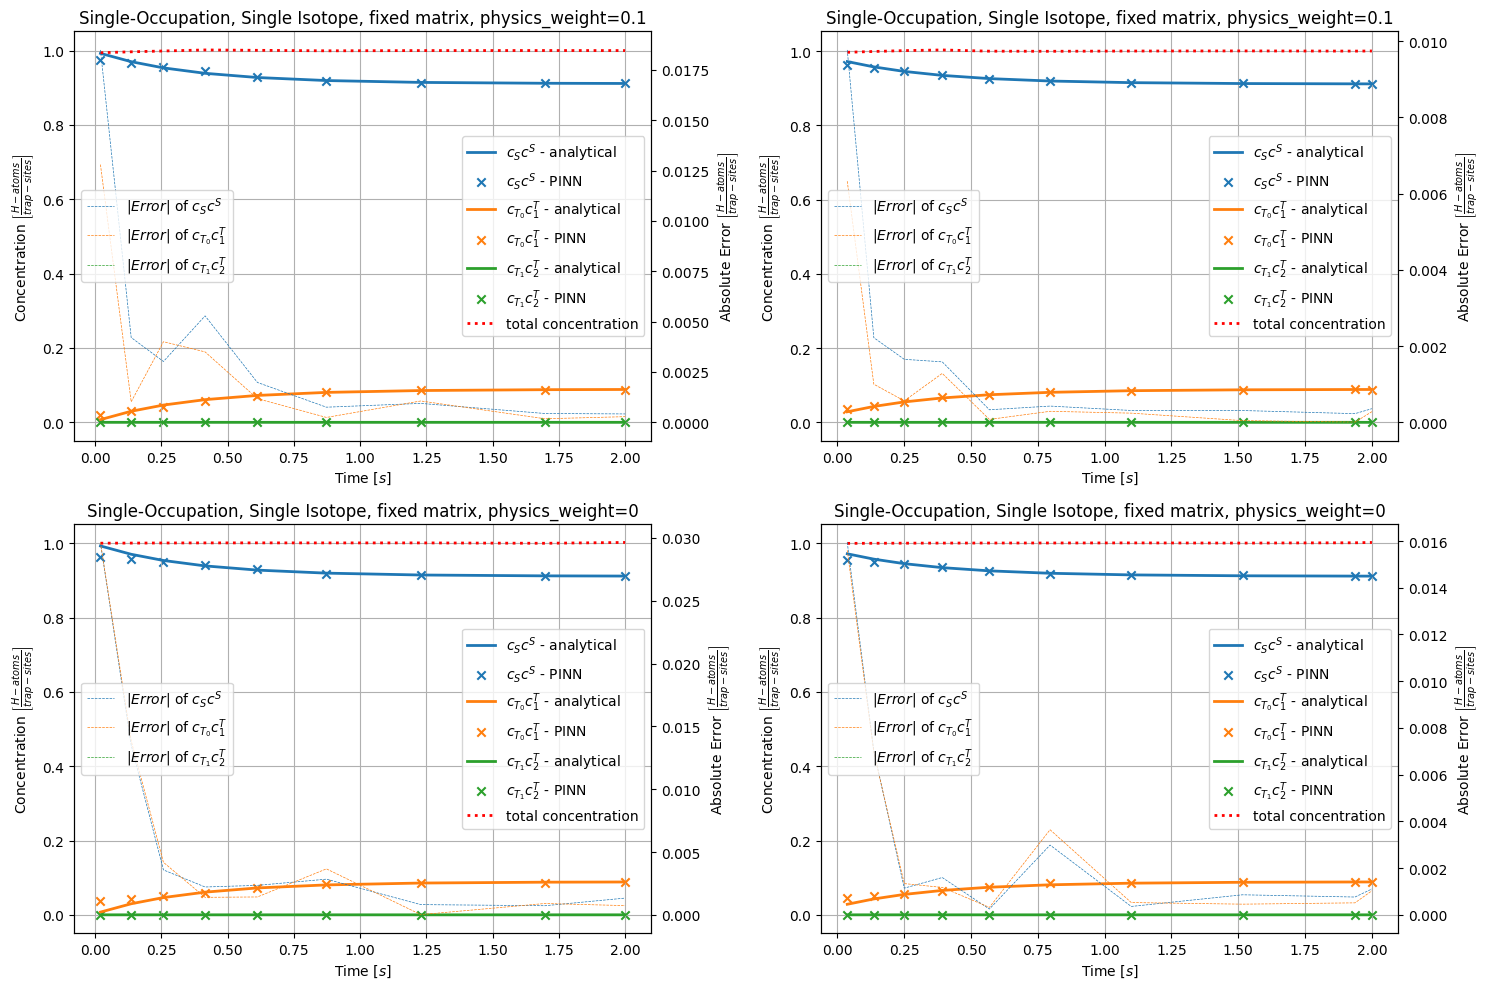

In [13]:
sosi_fixed = keras.models.load_model(
    "trained_models/SOSI_fixed.keras",
    compile=False,
)
sosi_fixed_physics = keras.models.load_model(
    "trained_models/SOSI_fixed_physics.keras",
    compile=False,
)
first_seed = 2
second_seed = 50

# this seed is just to recover the matrices from training
np.random.seed(1)
analytical_model = SingleOccupationSingleIsotope()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
np.random.seed(first_seed)
analytical_model.evaluate(sosi_fixed_physics)

plt.subplot(2, 2, 2)
np.random.seed(second_seed)
analytical_model.evaluate(sosi_fixed_physics)

plt.subplot(2, 2, 3)
np.random.seed(first_seed)
analytical_model.evaluate(sosi_fixed)

plt.subplot(2, 2, 4)
np.random.seed(second_seed)
analytical_model.evaluate(sosi_fixed)

plt.show()

# Single-Occupation, Single Isotope, random matrix model

## Training

### No physics loss

In [15]:
sosi_random_builder = SOSIRandom()
sosi_random, sosi_random_loss, (x_sosi_random, y_sosi_random) = sosi_random_builder.prepare(
    layer_sizes=[32, 64, 64],
    activations=["relu", "leaky_relu", "tanh", "linear"],
    physics_weight=0.0,
)
sosi_random.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=sosi_random_loss,
)
sosi_random.fit(
    x_sosi_random,
    y_sosi_random,
    batch_size=2**12,
    epochs=10,
    shuffle=True,
    validation_split=0.15,
)

Epoch 1/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1.6486 - val_loss: 0.3001
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1.2750 - val_loss: 0.2408
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.1984 - val_loss: 0.1778
Epoch 4/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.1268 - val_loss: 0.1433
Epoch 5/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.1318 - val_loss: 0.1371
Epoch 6/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.0918 - val_loss: 0.1067
Epoch 7/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1.0561 - val_loss: 0.1527
Epoch 8/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 1.0454 - val_loss: 0.1321
Epoch 9/10
 487/1038 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1.0123

KeyboardInterrupt: 

In [53]:
sosi_random.save('trained_models/SOSI_random.keras')

### Physics loss

In [54]:
full_model_physics, full_loss_physics, (x_full_physics,y_full_physics) = prepare_SOSI_random(physics_weight=0.1)
full_model_physics.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=full_loss_physics,
)
full_model_physics.fit(
    x_full_physics,
    y_full_physics,
    batch_size=2**12,
    epochs=10,
    shuffle=True,
    validation_split=0.15,
)

Epoch 1/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3644 - val_loss: 0.1546
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.2355 - val_loss: 0.1673
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.2276 - val_loss: 0.1433
Epoch 4/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.2154 - val_loss: 0.1299
Epoch 5/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.2087 - val_loss: 0.1346
Epoch 6/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.2051 - val_loss: 0.1329
Epoch 7/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.2025 - val_loss: 0.1457
Epoch 8/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.1975 - val_loss: 0.1415
Epoch 9/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.1975 - val_loss: 0.1677
Epoch 10/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.1937 - val_loss: 0.1442


In [56]:
full_model_physics.save('trained_models/SOSI_random_physics.keras')

## Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


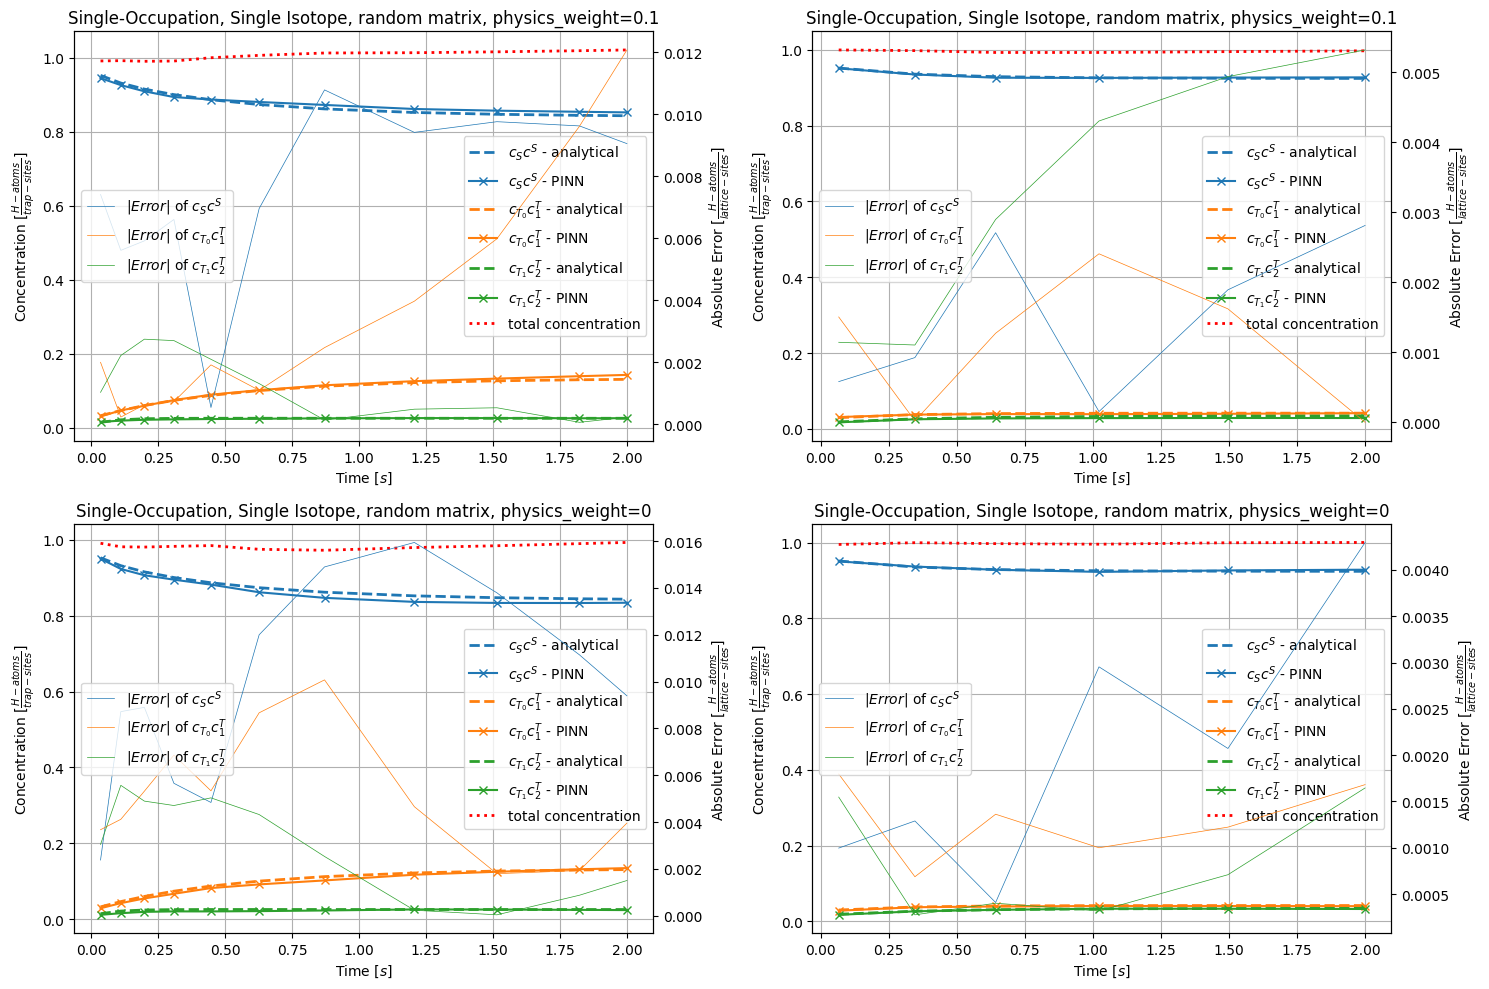

In [65]:
sosi_random = keras.models.load_model(
    "trained_models/SOSI_random.keras",
    compile=False,
)
full_model_physics = keras.models.load_model(
    "trained_models/SOSI_random_physics.keras",
    compile=False,
)

first_seed = 42
second_seed = 50

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
np.random.seed(first_seed)
SingleOccupationSingleIsotope().evaluate(full_model_physics,include_params = True)

plt.subplot(2, 2, 2)
np.random.seed(second_seed)
SingleOccupationSingleIsotope().evaluate(full_model_physics,include_params = True)

plt.subplot(2, 2, 3)
np.random.seed(first_seed)
SingleOccupationSingleIsotope().evaluate(sosi_random,include_params = True)

plt.subplot(2, 2, 4)
np.random.seed(second_seed)
SingleOccupationSingleIsotope().evaluate(sosi_random,include_params = True)

plt.show()

# Multi-Occupation, Multi-Isotope, fixed matrix model

## Training

### No physics loss

In [48]:
momi_fixed_model, momi_fixed_loss, (x_momi_fixed,y_momi_fixed) = prepare_MOMI_fixed(physics_weight=0)
momi_fixed_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=momi_fixed_loss,
)
momi_fixed_model.fit(
    x_momi_fixed,
    y_momi_fixed,
    batch_size=2**12,
    epochs=10,
    shuffle=True,
    validation_split=0.15,
)


Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0383 - val_loss: 0.0101
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0019 - val_loss: 0.0017


In [49]:
momi_fixed_model.save('trained_models/MOMI_fixed.keras')

### Physics loss

In [50]:
momi_fixed_physics_model, momi_fixed_physics_loss, (x_momi_fixed_physics,y_momi_fixed_physics) = prepare_MOMI_fixed(physics_weight=0.1)
momi_fixed_physics_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=momi_fixed_physics_loss,
)
momi_fixed_physics_model.fit(
    x_momi_fixed_physics,
    y_momi_fixed_physics,
    batch_size=2**12,
    epochs=10,
    shuffle=True,
    validation_split=0.15,
)


Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1278 - val_loss: 0.1008
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0999 - val_loss: 0.0976
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0975 - val_loss: 0.0960
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0959 - val_loss: 0.0947
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0946 - val_loss: 0.0939
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0942 - val_loss: 0.0938
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0941 - val_loss: 0.0934
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0938 - val_loss: 0.0933
Epoch 9/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0936 - val_loss: 0.0937
Epoch 10/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0936 - val_loss: 0.0939


In [51]:
momi_fixed_physics_model.save('trained_models/MOMI_fixed_physics.keras')

## Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


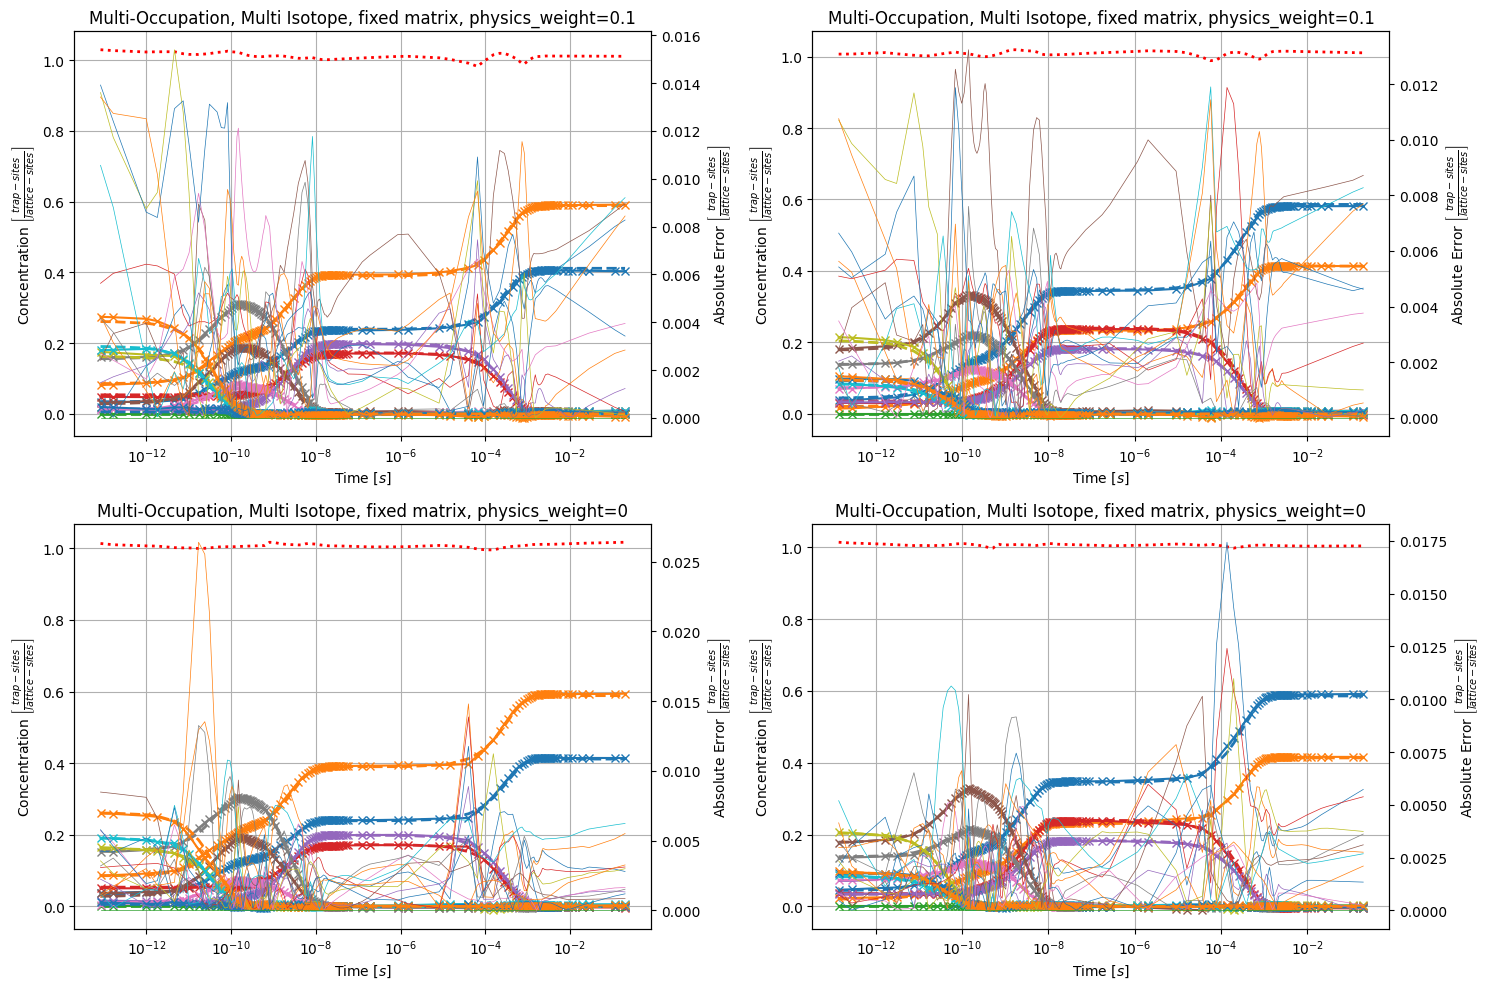

In [67]:
momi_fixed_model = keras.models.load_model(
    "trained_models/MOMI_fixed.keras",
    compile=False,
)
momi_fixed_physics_model = keras.models.load_model(
    "trained_models/MOMI_fixed_physics.keras",
    compile=False,
)

first_seed = 42
second_seed = 50

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
np.random.seed(first_seed)
MultiOccupationMultiIsotope().evaluate(momi_fixed_physics_model, legend = False)

plt.subplot(2, 2, 2)
np.random.seed(second_seed)
MultiOccupationMultiIsotope().evaluate(momi_fixed_physics_model, legend = False)

plt.subplot(2, 2, 3)
np.random.seed(first_seed)
MultiOccupationMultiIsotope().evaluate(momi_fixed_model, legend = False)

plt.subplot(2, 2, 4)
np.random.seed(second_seed)
MultiOccupationMultiIsotope().evaluate(momi_fixed_model, legend = False)

plt.show()